In [1]:
"""
Using MNIST, compare classification performance of:
1) logistic regression by itself,
2) logistic regression on outputs of an RBM, and
3) logistic regression on outputs of a stacks of RBMs / a DBN.
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import BernoulliRBM
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.neural_network import MLPClassifier

In [2]:
X, Y = datasets.load_digits(return_X_y=True)
X = X.astype(float)
X = X - X.min()
X = X / X.max()

# split into train, validation, and test data sets
X_train, X_test, Y_train, Y_test = train_test_split(X,       Y,       test_size=0.2, random_state=0)
X_train, X_val,  Y_train, Y_val  = train_test_split(X_train, Y_train, test_size=0.2, random_state=0)

In [7]:
Y_train

array([4, 2, 0, ..., 2, 8, 7])

[BernoulliRBM] Iteration 1, pseudo-likelihood = -25.73, time = 0.18s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -24.11, time = 0.32s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -24.83, time = 0.34s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -24.79, time = 0.35s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -24.62, time = 0.33s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -25.03, time = 0.34s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -26.25, time = 0.41s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -26.06, time = 0.31s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -25.14, time = 0.33s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -25.67, time = 0.31s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -25.33, time = 0.30s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -26.13, time = 0.29s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -25.02, time = 0.31s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -25.25, time = 0.33s
[BernoulliRBM] Iteration 15, 

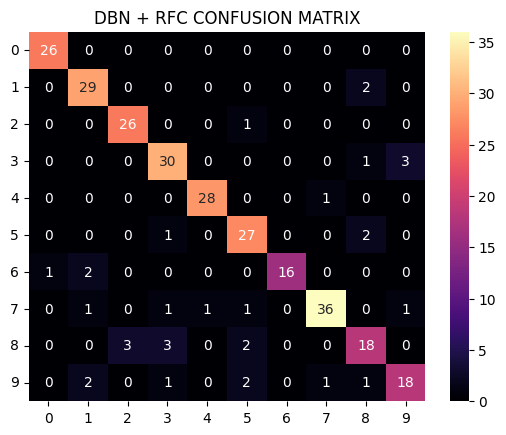

In [3]:
# --------------------------------------------------------------------------------
# set hyperparameters

learning_rate = 0.02 # from Erhan et el. (2010): median value in grid-search
total_units   =  800 # from Erhan et el. (2010): optimal for MNIST / only slightly worse than 1200 units when using InfiniteMNIST
total_epochs  =   50 # from Erhan et el. (2010): optimal for MNIST
batch_size    =  128 # seems like a representative sample; backprop literature often uses 256 or 512 samples

C = 100. # optimum for benchmark model according to sklearn docs: https://scikit-learn.org/stable/auto_examples/neural_networks/plot_rbm_logistic_classification.html#sphx-glr-auto-examples-neural-networks-plot-rbm-logistic-classification-py)

# TODO optimize using grid search, etc

# --------------------------------------------------------------------------------
# construct models

# RBM
rbm = BernoulliRBM(n_components=total_units, learning_rate=learning_rate, batch_size=batch_size, n_iter=total_epochs, verbose=1)

# "output layer"
logistic = LogisticRegression(C=C, solver='newton-cg', multi_class='multinomial', max_iter=200, verbose=1)
r_forest = RandomForestClassifier()
ml_classif = MLPClassifier()


models = []
model_names = [
    #"Logistic Base", 
    #"RBM + Logistic", 
    #"DBN + Logistic",
    "DBN + RFC"]
#models.append(Pipeline(steps=[('logistic', clone(logistic))]))                                              # base model / benchmark
#models.append(Pipeline(steps=[('rbm1', clone(rbm)), ('logistic', clone(logistic))]))                        # single RBM
#models.append(Pipeline(steps=[('rbm1', clone(rbm)), ('rbm2', clone(rbm)), ('logistic1', clone(logistic))]))  # RBM stack / DBN
models.append(Pipeline(steps=[('rbm1', clone(rbm)), ('rbm2', clone(rbm)), ('rfc', clone(r_forest))]))           # RBM stack / RANDOM FOREST

# --------------------------------------------------------------------------------
# train and evaluate models

for model, mn in zip(models, model_names):
    # train
    model.fit(X_train, Y_train)
    print(mn + " PERFORMANCE")

    # evaluate using validation set
    #print("Model performance:\n%s\n" % (classification_report(Y_val, model.predict(X_val))))

    print("Model Accuracy: " ,accuracy_score(Y_val, model.predict(X_val)))
    CM = confusion_matrix(model.predict(X_val), Y_val)
    
    ax = plt.subplot()
    ax.set_title(mn + " CONFUSION MATRIX")
    sns.heatmap(CM, annot=True, cmap="magma", ax=ax, fmt='d')
    plt.yticks(rotation=0)

    plt.show()

# TODO: after parameter optimization, evaluate on test set